In [1]:
%matplotlib inline
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from tqdm import trange

np.random.seed(2)

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [9]:
class GradNorm(nn.Module):
    def __init__(self, *modules):
        super(GradNorm, self).__init__()
        self.main = nn.Sequential(*modules)

    def forward(self, x):
        with torch.set_grad_enabled(True):
            x.requires_grad_(True)
            fx = self.main(x)
            grad_x = torch.autograd.grad(
                fx, x, torch.ones_like(fx), create_graph=True,
                retain_graph=True)[0]
            grad_norm = torch.norm(grad_x.view(grad_x.size(0), -1), dim=1)
            grad_norm = grad_norm.view(-1, *[1 for _ in range(len(fx.shape) - 1)])
            fx = (fx / (grad_norm + torch.abs(fx)))
        return fx

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
    
    def forward(self, x):
        return self.main(x)


class SNMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            torch.nn.utils.spectral_norm(nn.Linear(2, 64)),
            nn.ReLU(),
            torch.nn.utils.spectral_norm(nn.Linear(64, 1)),
        )
    
    def forward(self, x):
        return self.main(x)

    
class GNMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = GradNorm(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
    
    def forward(self, x):
        return self.main(x)


class MultiVariateNormalDataset(torch.utils.data.Dataset):
    def __init__(self, rv, n_samples=None):
        self.rv = rv
        self.n_samples = n_samples
        if self.n_samples is not None:
            self.samples = []
            for _ in range(self.n_samples):
                self.samples.append(rv.rvs())
    
    def __len__(self):
        if self.n_samples is not None:
            return self.n_samples
        else:
            return 10000

    def __getitem__(self, idx):
        if self.n_samples is not None:
            return torch.FloatTensor(self.samples[idx])
        else:
            return torch.FloatTensor(self.rv.rvs())

def gp(net_D, x0, x1, center):
    t = torch.rand(x1.size(0), 1).to(x1.device)
    t = t.expand(x1.size())

    interpolates = t * x1 + (1 - t) * x0
    interpolates.requires_grad_(True)
    disc_interpolates = net_D(interpolates)
    grad = torch.autograd.grad(
        outputs=disc_interpolates, inputs=interpolates,
        grad_outputs=torch.ones_like(disc_interpolates),
        create_graph=True, retain_graph=True)[0]

    grad_norm = torch.norm(torch.flatten(grad, start_dim=1), dim=1)
    loss_gp = torch.mean((grad_norm - center) ** 2)
    return loss_gp

def infiniteloop(dataloader):
    while True:
        for x in iter(dataloader):
            yield x

/home/yilun/Desktop/workspace/pytorch-gan-collections/venv/lib/python3.6/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


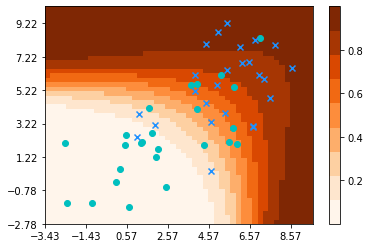

In [4]:
def gen_pts(n_pts, rv):
    xs, ys, probs = [], [], []
    for _ in range(n_pts):
        x, y = rv.rvs(size=1)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

n_pts = 25
n_grid = 50

mean1 = [2, 2]
cov1 = [[6, 4],
        [4, 6]]

mean2 = [6, 5]
cov2 = [[4, 1],
        [1, 4]]

# mean2 = [5, 4]
# cov2 = [[2, 1.1],
#         [1.1, 1]]

rv1 = multivariate_normal(mean1, cov1)
rv2 = multivariate_normal(mean2, cov2)

n_samples = 50
n_iter = 10000
batch_size = 32
lr = 0.001

device = 'cuda:0'

set_seed(0)
dataset0 = MultiVariateNormalDataset(rv1, n_samples=n_samples)
loader0 = torch.utils.data.DataLoader(dataset0, batch_size=batch_size//2, shuffle=True, drop_last=True)
dataset1 = MultiVariateNormalDataset(rv2)
loader1 = torch.utils.data.DataLoader(dataset1, batch_size=batch_size//2, drop_last=True)

xs1, ys1 = zip(*np.array(dataset0.samples))
xs2, ys2 = gen_pts(n_pts, rv2)
select = np.random.permutation(n_samples)[:n_pts]
xs1 = np.array(xs1)[select]
ys1 = np.array(ys1)[select]
x_min, x_max = min(xs1.min(), xs2.min()) - 1, max(xs1.max(), xs2.max()) + 1
y_min, y_max = min(ys1.min(), ys2.min()) - 1, max(ys1.max(), ys2.max()) + 1

xs = np.linspace(x_min, x_max, n_grid)
ys = np.linspace(y_min, y_max, n_grid)
opt_prob = []
for x in xs:
    for y in ys:
        prob1 = rv1.pdf([x, y])
        prob2 = rv2.pdf([x, y])
        opt_prob.append(prob2 / (prob1 + prob2))
opt_prob = np.array(opt_prob).reshape(n_grid, n_grid)

mesh_x, mesh_y = np.meshgrid(xs, ys)
cmap = plt.get_cmap('Oranges', 9)

plt.pcolormesh(mesh_x, mesh_y, opt_prob, cmap=cmap)
plt.colorbar()
plt.scatter(xs1, ys1, marker='o', c='c')
plt.scatter(xs2, ys2, marker='x', c='dodgerblue')
plt.xticks(np.arange(x_min, x_max, 2.0))
plt.yticks(np.arange(y_min, y_max, 2.0))
plt.show()

In [5]:
set_seed(0)
net = MLP().to(device)
optim = torch.optim.Adam(net.parameters(), lr=lr)

looper0 = infiniteloop(loader0)
looper1 = infiniteloop(loader1)
with trange(n_iter) as pbar:
    for step in pbar:
        fake = next(looper0).to(device)
        real = next(looper1).to(device)
        pred_real = net(real)
        pred_fake = net(fake)
#         loss_real = F.relu(1 - pred_real).mean()
#         loss_fake = F.relu(1 + pred_fake).mean()
        loss_real = F.binary_cross_entropy_with_logits(pred_real, torch.ones_like(pred_real))
        loss_fake = F.binary_cross_entropy_with_logits(pred_fake, torch.zeros_like(pred_fake))
        
        loss_D = loss_real + loss_fake
        
        optim.zero_grad()
        loss_D.backward()
        optim.step()
        
        pbar.set_postfix_str('loss_D: %.4f' % loss_D)

100%|██████████| 10000/10000 [01:09<00:00, 143.66it/s, loss_D: 0.6621]


/home/yilun/Desktop/workspace/pytorch-gan-collections/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


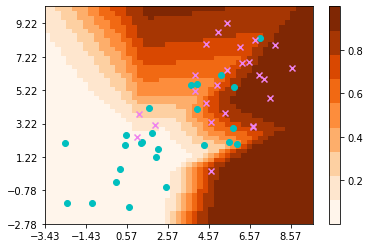

In [6]:
probs = []
x = np.stack([mesh_x.reshape(-1), mesh_y.reshape(-1)], axis=1)
with torch.no_grad():
    probs = (net(torch.FloatTensor(x).to(device)))
#     probs = (torch.clamp(probs, -1, 1) + 1) / 2
    probs = torch.sigmoid(probs)
probs = probs.cpu().numpy().reshape(n_grid, n_grid)

plt.pcolormesh(mesh_x, mesh_y, probs, cmap=cmap)
plt.colorbar()
plt.scatter(xs1, ys1, marker='o', c='c')
plt.scatter(xs2, ys2, marker='x', c='violet')
plt.xticks(np.arange(x_min, x_max, 2.0))
plt.yticks(np.arange(y_min, y_max, 2.0))
plt.show()

/home/yilun/Desktop/workspace/pytorch-gan-collections/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


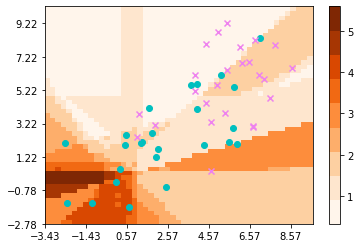

In [7]:
probs = []
x = torch.FloatTensor(np.stack([mesh_x.reshape(-1), mesh_y.reshape(-1)], axis=1))
x.requires_grad_(True)
fx = net(x.to(device))
grad_x = torch.autograd.grad(fx, x, torch.ones_like(fx))[0]
grad_norm = torch.norm(grad_x.view(grad_x.size(0), -1), dim=1)
grad_norm = grad_norm.cpu().numpy().reshape(n_grid, n_grid)

plt.pcolormesh(mesh_x, mesh_y, grad_norm, cmap=cmap)
plt.colorbar()
plt.scatter(xs1, ys1, marker='o', c='c')
plt.scatter(xs2, ys2, marker='x', c='violet')
plt.xticks(np.arange(x_min, x_max, 2.0))
plt.yticks(np.arange(y_min, y_max, 2.0))
plt.show()

In [10]:
set_seed(0)
alpha = 1
net_gp0 = MLP().to(device)
optim = torch.optim.Adam(net_gp0.parameters(), lr=lr)

looper0 = infiniteloop(loader0)
looper1 = infiniteloop(loader1)
with trange(n_iter) as pbar:
    for step in pbar:
        fake = next(looper0).to(device)
        real = next(looper1).to(device)
        pred_real = net(real)
        pred_fake = net(fake)
#         loss_real = F.relu(1 - pred_real).mean()
#         loss_fake = F.relu(1 + pred_fake).mean()
        loss_real = F.binary_cross_entropy_with_logits(pred_real, torch.ones_like(pred_real))
        loss_fake = F.binary_cross_entropy_with_logits(pred_fake, torch.zeros_like(pred_fake))
        
        loss_D = loss_real + loss_fake
        loss_gp = gp(net_gp0, fake, real, center=0)
        loss = loss_D + alpha * loss_gp
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        pbar.set_postfix_str('loss_D: %.4f, loss_gp: %.4f' % (loss_D, loss_gp))

100%|██████████| 10000/10000 [01:33<00:00, 107.49it/s, loss_D: 0.7044, loss_gp: 0.0000]


/home/yilun/Desktop/workspace/pytorch-gan-collections/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


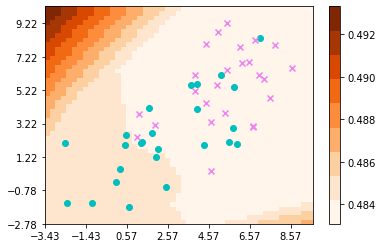

In [11]:
probs = []
x = np.stack([mesh_x.reshape(-1), mesh_y.reshape(-1)], axis=1)
with torch.no_grad():
    probs = (net_gp0(torch.FloatTensor(x).to(device)))
#     probs = (torch.clamp(probs, -1, 1) + 1) / 2
    probs = torch.sigmoid(probs)
probs = probs.cpu().numpy().reshape(n_grid, n_grid)

plt.pcolormesh(mesh_x, mesh_y, probs, cmap=cmap)
plt.colorbar()
plt.scatter(xs1, ys1, marker='o', c='c')
plt.scatter(xs2, ys2, marker='x', c='violet')
plt.xticks(np.arange(x_min, x_max, 2.0))
plt.yticks(np.arange(y_min, y_max, 2.0))
plt.show()

/home/yilun/Desktop/workspace/pytorch-gan-collections/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


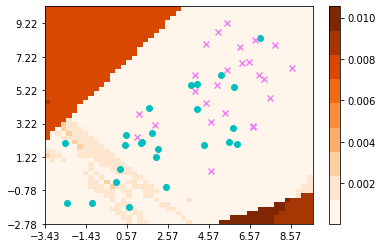

In [12]:
probs = []
x = torch.FloatTensor(np.stack([mesh_x.reshape(-1), mesh_y.reshape(-1)], axis=1))
x.requires_grad_(True)
fx = net_gp0(x.to(device))
grad_x = torch.autograd.grad(fx, x, torch.ones_like(fx))[0]
grad_norm = torch.norm(grad_x.view(grad_x.size(0), -1), dim=1)
grad_norm = grad_norm.cpu().numpy().reshape(n_grid, n_grid)

plt.pcolormesh(mesh_x, mesh_y, grad_norm, cmap=cmap)
plt.colorbar()
plt.scatter(xs1, ys1, marker='o', c='c')
plt.scatter(xs2, ys2, marker='x', c='violet')
plt.xticks(np.arange(x_min, x_max, 2.0))
plt.yticks(np.arange(y_min, y_max, 2.0))
plt.show()

In [13]:
set_seed(0)
alpha = 1
net_gp1 = MLP().to(device)
optim = torch.optim.Adam(net_gp1.parameters(), lr=lr)

looper0 = infiniteloop(loader0)
looper1 = infiniteloop(loader1)
with trange(n_iter) as pbar:
    for step in pbar:
        fake = next(looper0).to(device)
        real = next(looper1).to(device)
        pred_real = net(real)
        pred_fake = net(fake)
#         loss_real = F.relu(1 - pred_real).mean()
#         loss_fake = F.relu(1 + pred_fake).mean()
        loss_real = F.binary_cross_entropy_with_logits(pred_real, torch.ones_like(pred_real))
        loss_fake = F.binary_cross_entropy_with_logits(pred_fake, torch.zeros_like(pred_fake))
        
        loss_D = loss_real + loss_fake
        loss_gp = gp(net_gp1, fake, real, center=1)
        loss = loss_D + alpha * loss_gp

        optim.zero_grad()
        loss.backward()
        optim.step()
        
        pbar.set_postfix_str('loss_D: %.4f, loss_gp: %.4f' % (loss_D, loss_gp))

100%|██████████| 10000/10000 [01:33<00:00, 107.12it/s, loss_D: 0.7044, loss_gp: 0.0000]


/home/yilun/Desktop/workspace/pytorch-gan-collections/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


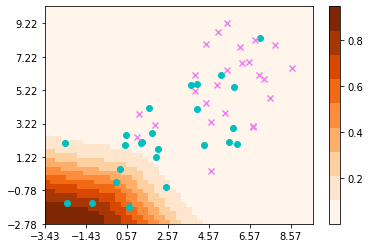

In [14]:
probs = []
x = np.stack([mesh_x.reshape(-1), mesh_y.reshape(-1)], axis=1)
with torch.no_grad():
    probs = (net_gp1(torch.FloatTensor(x).to(device)))
#     probs = (torch.clamp(probs, -1, 1) + 1) / 2
    probs = torch.sigmoid(probs)
probs = probs.cpu().numpy().reshape(n_grid, n_grid)

plt.pcolormesh(mesh_x, mesh_y, probs, cmap=cmap)
plt.colorbar()
plt.scatter(xs1, ys1, marker='o', c='c')
plt.scatter(xs2, ys2, marker='x', c='violet')
plt.xticks(np.arange(x_min, x_max, 2.0))
plt.yticks(np.arange(y_min, y_max, 2.0))
plt.show()

/home/yilun/Desktop/workspace/pytorch-gan-collections/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


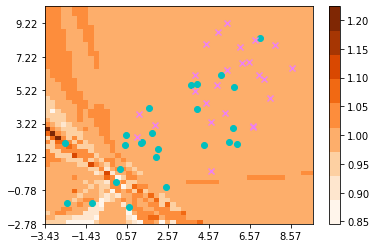

In [15]:
probs = []
x = torch.FloatTensor(np.stack([mesh_x.reshape(-1), mesh_y.reshape(-1)], axis=1))
x.requires_grad_(True)
fx = net_gp1(x.to(device))
grad_x = torch.autograd.grad(fx, x, torch.ones_like(fx))[0]
grad_norm = torch.norm(grad_x.view(grad_x.size(0), -1), dim=1)
grad_norm = grad_norm.cpu().numpy().reshape(n_grid, n_grid)

plt.pcolormesh(mesh_x, mesh_y, grad_norm, cmap=cmap)
plt.colorbar()
plt.scatter(xs1, ys1, marker='o', c='c')
plt.scatter(xs2, ys2, marker='x', c='violet')
plt.xticks(np.arange(x_min, x_max, 2.0))
plt.yticks(np.arange(y_min, y_max, 2.0))
plt.show()

In [ ]:
set_seed(0)
net_sn = SNMLP().to(device)
optim = torch.optim.Adam(net_sn.parameters(), lr=lr)

looper0 = infiniteloop(loader0)
looper1 = infiniteloop(loader1)
loss_fn = nn.BCEWithLogitsLoss()
with trange(n_iter) as pbar:
    for step in pbar:
        fake = next(looper0).to(device)
        real = next(looper1).to(device)
        pred_real = net(real)
        pred_fake = net(fake)
#         loss_real = F.relu(1 - pred_real).mean()
#         loss_fake = F.relu(1 + pred_fake).mean()
        loss_real = F.binary_cross_entropy_with_logits(pred_real, torch.ones_like(pred_real))
        loss_fake = F.binary_cross_entropy_with_logits(pred_fake, torch.zeros_like(pred_fake))
        
        loss_D = loss_real + loss_fake
        loss = loss_D
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        pbar.set_postfix_str('loss_D: %.4f' % loss_D)

 62%|██████▏   | 6241/10000 [00:43<00:25, 144.78it/s, loss_D: 0.6953]

In [ ]:
probs = []
x = np.stack([mesh_x.reshape(-1), mesh_y.reshape(-1)], axis=1)
with torch.no_grad():
    probs = (net_gp0(torch.FloatTensor(x).to(device)))
#     probs = (torch.clamp(probs, -1, 1) + 1) / 2
    probs = torch.sigmoid(probs)
probs = probs.cpu().numpy().reshape(n_grid, n_grid)

plt.pcolormesh(mesh_x, mesh_y, probs, cmap=cmap)
plt.colorbar()
plt.scatter(xs1, ys1, marker='o', c='c')
plt.scatter(xs2, ys2, marker='x', c='violet')
plt.xticks(np.arange(x_min, x_max, 2.0))
plt.yticks(np.arange(y_min, y_max, 2.0))
plt.show()

In [ ]:
probs = []
x = torch.FloatTensor(np.stack([mesh_x.reshape(-1), mesh_y.reshape(-1)], axis=1))
x.requires_grad_(True)
fx = net_sn(x.to(device))
grad_x = torch.autograd.grad(fx, x, torch.ones_like(fx))[0]
grad_norm = torch.norm(grad_x.view(grad_x.size(0), -1), dim=1)
grad_norm = grad_norm.cpu().numpy().reshape(n_grid, n_grid)

plt.pcolormesh(mesh_x, mesh_y, grad_norm, cmap=cmap)
plt.colorbar()
plt.scatter(xs1, ys1, marker='o', c='c')
plt.scatter(xs2, ys2, marker='x', c='violet')
plt.xticks(np.arange(x_min, x_max, 2.0))
plt.yticks(np.arange(y_min, y_max, 2.0))
plt.show()

In [ ]:
set_seed(0)
net_gn = GNMLP().to(device)
optim = torch.optim.Adam(net_gn.parameters(), lr=lr)

looper0 = infiniteloop(loader0)
looper1 = infiniteloop(loader1)
with trange(n_iter) as pbar:
    for step in pbar:
        fake = next(looper0).to(device)
        real = next(looper1).to(device)
        pred_real = net(real)
        pred_fake = net(fake)
#         loss_real = F.relu(1 - pred_real).mean()
#         loss_fake = F.relu(1 + pred_fake).mean()
        loss_real = F.binary_cross_entropy_with_logits(pred_real, torch.ones_like(pred_real))
        loss_fake = F.binary_cross_entropy_with_logits(pred_fake, torch.zeros_like(pred_fake))
        
        loss_D = loss_real + loss_fake
        loss = loss_D
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        pbar.set_postfix_str('loss_D: %.4f' % loss_D)

In [ ]:
probs = []
x = np.stack([mesh_x.reshape(-1), mesh_y.reshape(-1)], axis=1)
with torch.no_grad():
    probs = (net_gp0(torch.FloatTensor(x).to(device)))
    probs = (torch.clamp(probs, -1, 1) + 1) / 2
#     probs = torch.sigmoid(probs)
probs = probs.cpu().numpy().reshape(n_grid, n_grid)

plt.pcolormesh(mesh_x, mesh_y, probs, cmap=cmap)
plt.colorbar()
plt.scatter(xs1, ys1, marker='o', c='c')
plt.scatter(xs2, ys2, marker='x', c='violet')
plt.xticks(np.arange(x_min, x_max, 2.0))
plt.yticks(np.arange(y_min, y_max, 2.0))
plt.show()

In [ ]:
probs = []
x = torch.FloatTensor(np.stack([mesh_x.reshape(-1), mesh_y.reshape(-1)], axis=1))
x.requires_grad_(True)
fx = net_gn(x.to(device))
grad_x = torch.autograd.grad(fx, x, torch.ones_like(fx))[0]
grad_norm = torch.norm(grad_x.view(grad_x.size(0), -1), dim=1)
grad_norm = grad_norm.cpu().numpy().reshape(n_grid, n_grid)

plt.pcolormesh(mesh_x, mesh_y, grad_norm, cmap=cmap)
plt.colorbar()
plt.scatter(xs1, ys1, marker='o', c='c')
plt.scatter(xs2, ys2, marker='x', c='violet')
plt.xticks(np.arange(x_min, x_max, 2.0))
plt.yticks(np.arange(y_min, y_max, 2.0))
plt.show()